## FICTOMETER for TEXT CLASSIFICATION into FICTION and NON-FICTION

In [1]:
# Full details of the FICTOMETER algorithm : https://medium.com/@atmabodha/fictometer-a-simple-and-explainable-algorithm-for-sentiment-analysis-31186d2a8c7e

In [21]:
import nltk
from nltk.corpus import brown
nltk.download('brown')
import pandas as pd

from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [3]:
def n_adj(text):
    adj=0
    for i in text:
        if i[0] == 'J':
            adj=adj+1
    return adj

def n_noun(text):
    noun=0
    for i in text:
        if ((i[0] == 'N') and (i[1] != 'C')):
            noun=noun+1
    return noun

def n_verb(text):
    verb=0
    for i in text:
        if i[0] == 'V':
            verb=verb+1
    return verb

def n_pronoun(text):
    pronoun=0
    for i in text:
        if (i[0] == 'P') or (i[:3] in ['WP$','WPO','WPS']):
            pronoun=pronoun+1
    return pronoun

def n_adv(text):
    adv=0
    for i in text:
        if (i[0] == 'R') or (i[:3] in ['WRB']):
            adv=adv+1
    return adv

def func_utag(tag):
    if tag[0] == 'J' or tag == 'ADJ':
        utag='ADJ'
    elif ((tag[0] == 'N') and (tag[1] != 'C')) or tag == 'NOUN':
        utag='NOUN'
    elif tag[0] == 'V' or tag == 'VERB':
        utag='VERB'
    elif (tag[0] == 'P') or (tag[:3] in ['WP$','WPO','WPS']) or tag == 'PRON':
        utag='PRON'
    elif (tag[0] == 'R') or (tag[:3] in ['WRB']) or tag == 'ADV':
        utag='ADV'
    else:
        utag='unknown'
    return utag

def func_is5tag(tag):
    if tag in ['ADJ','ADV','NOUN','PRON','VERB']:
        is5tag=True
    else:
        is5tag=False
    return is5tag

In [23]:
brownpostable=pd.DataFrame(columns=['category','filename','ADJ','ADV','NOUN','VERB','PRON','RADJPRON','RADVADJ'])

In [24]:
for i in tqdm(brown.categories()):
    for j in brown.fileids(categories=i):
        taggedwords=brown.tagged_words(j)
        taglist=[]
        for k in taggedwords:
            taglist.append(k[1])
        adj=n_adj(taglist)
        adv=n_adv(taglist)
        noun=n_noun(taglist)
        verb=n_verb(taglist)
        pronoun=n_pronoun(taglist)
        brownpostable=brownpostable.append({'category' : i,'filename' : j, 'ADJ' : int(adj), 'ADV' : int(adv), 'NOUN' : int(noun), 'VERB' : int(verb), 'PRON' : int(pronoun)},ignore_index=True)

100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


In [25]:
brownpostable

,category,filename,ADJ,ADV,NOUN,VERB,PRON,RADJPRON,RADVADJ
0,adventure,cn01,72,134,390,321,329,NaN,NaN
1,adventure,cn02,71,144,423,328,312,NaN,NaN
2,adventure,cn03,58,98,487,352,219,NaN,NaN
3,adventure,cn04,121,116,466,320,242,NaN,NaN
4,adventure,cn05,74,142,363,301,339,NaN,NaN
...,...,...,...,...,...,...,...,...,...
495,science_fiction,cm02,128,116,463,255,177,NaN,NaN
496,science_fiction,cm03,109,135,415,223,205,NaN,NaN
497,science_fiction,cm04,125,134,422,265,244,NaN,NaN
498,science_fiction,cm05,183,84,531,247,181,NaN,NaN


In [26]:
for i in range(len(brownpostable)):
    adj=brownpostable.ADJ.iloc[i]
    adv=brownpostable.ADV.iloc[i]
    pronoun=brownpostable.PRON.iloc[i]
    brownpostable.RADJPRON.iloc[i]=adj/pronoun
    brownpostable.RADVADJ.iloc[i]=adv/adj

In [27]:
brownpostable

,category,filename,ADJ,ADV,NOUN,VERB,PRON,RADJPRON,RADVADJ
0,adventure,cn01,72,134,390,321,329,0.218845,1.861111
1,adventure,cn02,71,144,423,328,312,0.227564,2.028169
2,adventure,cn03,58,98,487,352,219,0.26484,1.689655
3,adventure,cn04,121,116,466,320,242,0.5,0.958678
4,adventure,cn05,74,142,363,301,339,0.218289,1.918919
...,...,...,...,...,...,...,...,...,...
495,science_fiction,cm02,128,116,463,255,177,0.723164,0.90625
496,science_fiction,cm03,109,135,415,223,205,0.531707,1.238532
497,science_fiction,cm04,125,134,422,265,244,0.512295,1.072
498,science_fiction,cm05,183,84,531,247,181,1.01105,0.459016


In [28]:
brown2=brownpostable.copy()
for i in ['news','reviews','government','learned','hobbies']:
    brown2=brown2.replace(to_replace=i,value='nonfiction')

for i in ['fiction','mystery','science_fiction','adventure','romance']:
    brown2=brown2.replace(to_replace=i,value='fiction')
    
index_names=brown2[(brown2['category'] != 'fiction') & (brown2['category'] != 'nonfiction')].index
brown2.drop(index_names,inplace=True)

In [29]:
brown3=brown2.replace(to_replace='nonfiction',value='0')
brown3=brown3.replace(to_replace='fiction',value='1')

In [30]:
brown3

,category,filename,ADJ,ADV,NOUN,VERB,PRON,RADJPRON,RADVADJ
0,1,cn01,72,134,390,321,329,0.218845,1.861111
1,1,cn02,71,144,423,328,312,0.227564,2.028169
2,1,cn03,58,98,487,352,219,0.264840,1.689655
3,1,cn04,121,116,466,320,242,0.500000,0.958678
4,1,cn05,74,142,363,301,339,0.218289,1.918919
...,...,...,...,...,...,...,...,...,...
495,1,cm02,128,116,463,255,177,0.723164,0.906250
496,1,cm03,109,135,415,223,205,0.531707,1.238532
497,1,cm04,125,134,422,265,244,0.512295,1.072000
498,1,cm05,183,84,531,247,181,1.011050,0.459016


In [31]:
x=brown3.drop(columns=['category','filename','PRON','ADJ','ADV','NOUN','VERB'])
y=brown3.category

In [32]:
x

,RADJPRON,RADVADJ
0,0.218845,1.861111
1,0.227564,2.028169
2,0.264840,1.689655
3,0.500000,0.958678
4,0.218289,1.918919
...,...,...
495,0.723164,0.906250
496,0.531707,1.238532
497,0.512295,1.072000
498,1.011050,0.459016


In [33]:
y

0      1
1      1
2      1
3      1
4      1
      ..
495    1
496    1
497    1
498    1
499    1
Name: category, Length: 324, dtype: object

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(x_train,y_train)

LogisticRegression()

In [40]:
y_pred=logreg.predict(x_train)
accuracy = metrics.accuracy_score(y_train,y_pred)
print("Training Accuracy : ",accuracy)

Training Accuracy :  0.972972972972973


In [41]:
y_pred=logreg.predict(x_test)
accuracy = metrics.accuracy_score(y_test,y_pred)
print("Testing Accuracy : ", accuracy)

Testing Accuracy :  0.9384615384615385


In [42]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[40,  1],
       [ 3, 21]])

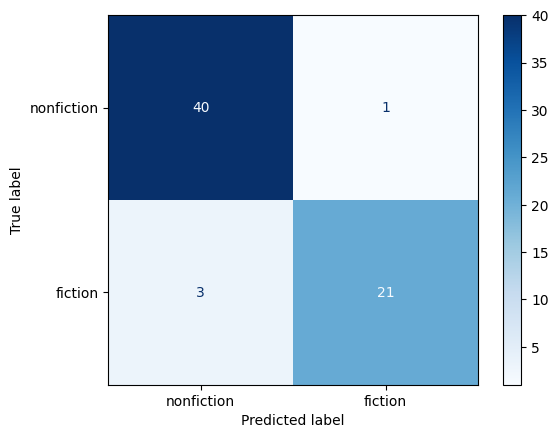

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['nonfiction', 'fiction'])
disp.plot(cmap=plt.cm.Blues)  # plot the confusion matrix
plt.show()  # show the plot